# Mortgage Interest Rate Comparison Analysis

This notebook compares a fixed mortgage rate vs. variable rate scenarios to determine the breakeven point.

## Loan Details

- **Total Price**: 2,695,000 SEK
- **Down Payment**: 404,000 SEK
- **Loan Amount**: 2,291,000 SEK
- **Amortization Rate**: 2.0% per year (Swedish requirement)
- **Fixed Rate Option**: 2.57% (locked for 3 years)
- **Variable Rate Evolution**:
  - Year 1: 2.35% → 2.50% (+0.15%)
  - Year 2: 2.50% → 2.80% (+0.30%)
  - Year 3: 2.80% → 4.00% (+1.20%)

We'll analyze 15 scenarios with different rate progression patterns and compare total costs including both interest and amortization.

In [1]:
# Install required packages
!pip install numpy pandas matplotlib seaborn -q

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

## Define Loan Parameters

In [ ]:
# Loan details
total_price = 2_695_000
down_payment = 404_000
loan_amount = total_price - down_payment
amortization_rate = 2.0  # 2% per year (Swedish requirement)

# Rate options
fixed_rate = 2.57
variable_rate_start = 2.35
year1_end = 2.50  # End of year 1
year2_end = 2.80  # End of year 2
variable_rate_end = 4.0  # End of year 3

# Time periods
total_months = 36  # 3 years
year1_months = 12  # First year
year2_months = 12  # Second year
year3_months = 12  # Third year

print(f"Loan Amount: {loan_amount:,.0f} SEK")
print(f"Amortization Rate: {amortization_rate}% per year")
print(f"Fixed Interest Rate: {fixed_rate}%")
print(f"Variable Rate Evolution:")
print(f"  Year 1: {variable_rate_start}% → {year1_end}%")
print(f"  Year 2: {year1_end}% → {year2_end}%")
print(f"  Year 3: {year2_end}% → {variable_rate_end}%")
print(f"Analysis Period: {total_months} months")

Loan Amount: 2,291,000 SEK
Fixed Rate: 2.57%
Variable Rate Evolution:
  Year 1: 2.35% → 2.5%
  Year 2: 2.5% → 2.8%
  Year 3: 2.8% → 4.0%
Analysis Period: 36 monthss


## Create Rate Increase Scenarios There are two main scenario families:

- **Statistical Percentile Scenarios (P10, P25, P50, P75, P90):**
  - These follow their own independent progression for all three years, not tied to bank estimates.
  - Each percentile represents a different statistical outcome, from very optimistic (P10) to very pessimistic (P90).
  - The rate evolves smoothly from the starting value to the final percentile target over 36 months.

- **Expert/Bank Forecast Scenarios:**
  - These use the bank's estimates for years 1 and 2:
    - Year 1 (months 1-12): 2.35% → 2.50% (+0.15%)
    - Year 2 (months 13-24): 2.50% → 2.80% (+0.30%)
  - Year 3 (months 25-36) follows the expert or bank forecast (e.g., central bank, commercial bank, bull/bear cases).

**Year 3 is uncertain** – we test multiple possibilities:
- High increase (rates jump to 4.00% or higher)
- Moderate increase (rates rise to 2.80–3.20%)
- Rate decrease (rates drop to 2.50–2.70%)
- Extreme cases (sharp rise or drop)

This approach provides a scientific and comprehensive view of possible interest rate evolutions, allowing for both statistical and expert-driven analysis.

In [39]:
def create_rate_schedule(scenario_type, year3_final_rate=None, use_bank_yr12=True):
    """
    Create different rate increase patterns.
    
    Scenarios:
    1. Linear: Steady linear increase/decrease each year
    2. Early Jump: Large change early in each period, then moderate
    3. Late Jump: Moderate early, large change late in each period
    4. Stepped: Quarterly step changes
    5. Accelerating: Slow start, accelerating changes
    
    year3_final_rate: Override final rate for year 3 (default is 4.0%)
    use_bank_yr12: If True, use bank estimates for years 1-2. If False, extrapolate from final rate
    """
    rates = []
    
    # Determine year 3 final rate
    if year3_final_rate is None:
        year3_final_rate = variable_rate_end
    
    if use_bank_yr12:
        # Use bank's estimates for years 1-2
        # Year 1: increase from 2.35% to 2.50%
        year1_increase = year1_end - variable_rate_start  # 0.15%
        
        if scenario_type == 1:  # Linear increase
            for i in range(year1_months):
                rates.append(variable_rate_start + (year1_increase / year1_months) * (i + 1))
        elif scenario_type == 2:  # Early Jump
            for i in range(4):
                rates.append(variable_rate_start + (year1_increase / 4) * (i + 1))
            rates.extend([year1_end] * 8)
        elif scenario_type == 3:  # Late Jump
            rates.extend([variable_rate_start] * 8)
            for i in range(4):
                rates.append(variable_rate_start + (year1_increase / 4) * (i + 1))
        elif scenario_type == 4:  # Stepped
            step = year1_increase / 4
            for quarter in range(4):
                rate = variable_rate_start + step * (quarter + 1)
                rates.extend([rate] * 3)
        elif scenario_type == 5:  # Accelerating
            for i in range(year1_months):
                progress = ((i + 1) / year1_months) ** 1.5
                rates.append(variable_rate_start + year1_increase * progress)
        
        # Year 2: increase from 2.50% to 2.80%
        year2_increase = year2_end - year1_end  # 0.30%
        
        if scenario_type == 1:  # Linear
            for i in range(year2_months):
                rates.append(year1_end + (year2_increase / year2_months) * (i + 1))
        elif scenario_type == 2:  # Early Jump
            for i in range(4):
                rates.append(year1_end + (year2_increase / 4) * (i + 1))
            rates.extend([year2_end] * 8)
        elif scenario_type == 3:  # Late Jump
            rates.extend([year1_end] * 8)
            for i in range(4):
                rates.append(year1_end + (year2_increase / 4) * (i + 1))
        elif scenario_type == 4:  # Stepped
            step = year2_increase / 4
            for quarter in range(4):
                rate = year1_end + step * (quarter + 1)
                rates.extend([rate] * 3)
        elif scenario_type == 5:  # Accelerating
            for i in range(year2_months):
                progress = ((i + 1) / year2_months) ** 1.5
                rates.append(year1_end + year2_increase * progress)
        
        # Year 3: change from 2.80% to year3_final_rate
        year3_change = year3_final_rate - year2_end
        year3_start = year2_end
    else:
        # Extrapolate consistent pattern across all 3 years
        # Calculate what the rate should be at each year-end to reach final rate smoothly
        total_change = year3_final_rate - variable_rate_start
        
        # Linear distribution across 3 years
        year1_target = variable_rate_start + (total_change / 3)
        year2_target = variable_rate_start + (2 * total_change / 3)
        year3_target = year3_final_rate
        
        # Year 1
        year1_change = year1_target - variable_rate_start
        if scenario_type == 1:  # Linear
            for i in range(year1_months):
                rates.append(variable_rate_start + (year1_change / year1_months) * (i + 1))
        elif scenario_type == 2:  # Early Jump
            for i in range(4):
                rates.append(variable_rate_start + (year1_change / 4) * (i + 1))
            rates.extend([year1_target] * 8)
        elif scenario_type == 3:  # Late Jump
            rates.extend([variable_rate_start] * 8)
            for i in range(4):
                rates.append(variable_rate_start + (year1_change / 4) * (i + 1))
        elif scenario_type == 4:  # Stepped
            step = year1_change / 4
            for quarter in range(4):
                rate = variable_rate_start + step * (quarter + 1)
                rates.extend([rate] * 3)
        elif scenario_type == 5:  # Accelerating
            for i in range(year1_months):
                progress = ((i + 1) / year1_months) ** 1.5
                rates.append(variable_rate_start + year1_change * progress)
        
        # Year 2
        year2_change = year2_target - year1_target
        if scenario_type == 1:  # Linear
            for i in range(year2_months):
                rates.append(year1_target + (year2_change / year2_months) * (i + 1))
        elif scenario_type == 2:  # Early Jump
            for i in range(4):
                rates.append(year1_target + (year2_change / 4) * (i + 1))
            rates.extend([year2_target] * 8)
        elif scenario_type == 3:  # Late Jump
            rates.extend([year1_target] * 8)
            for i in range(4):
                rates.append(year1_target + (year2_change / 4) * (i + 1))
        elif scenario_type == 4:  # Stepped
            step = year2_change / 4
            for quarter in range(4):
                rate = year1_target + step * (quarter + 1)
                rates.extend([rate] * 3)
        elif scenario_type == 5:  # Accelerating
            for i in range(year2_months):
                progress = ((i + 1) / year2_months) ** 1.5
                rates.append(year1_target + year2_change * progress)
        
        # Year 3
        year3_change = year3_target - year2_target
        year3_start = year2_target
    
    # Year 3 (same for both bank and percentile scenarios)
    if scenario_type == 1:  # Linear
        for i in range(year3_months):
            rates.append(year3_start + (year3_change / year3_months) * (i + 1))
    elif scenario_type == 2:  # Early Jump/Drop
        if abs(year3_change) > 0.001:
            jump_months = min(4, year3_months)
            for i in range(jump_months):
                rates.append(year3_start + (year3_change / jump_months) * (i + 1))
            rates.extend([year3_final_rate] * (year3_months - jump_months))
        else:
            rates.extend([year3_start] * year3_months)
    elif scenario_type == 3:  # Late Jump/Drop
        if abs(year3_change) > 0.001:
            jump_months = min(4, year3_months)
            rates.extend([year3_start] * (year3_months - jump_months))
            for i in range(jump_months):
                rates.append(year3_start + (year3_change / jump_months) * (i + 1))
        else:
            rates.extend([year3_start] * year3_months)
    elif scenario_type == 4:  # Stepped
        if abs(year3_change) > 0.001:
            step = year3_change / 4
            for quarter in range(4):
                rate = year3_start + step * (quarter + 1)
                rates.extend([rate] * 3)
        else:
            rates.extend([year3_start] * year3_months)
    elif scenario_type == 5:  # Accelerating
        if abs(year3_change) > 0.001:
            for i in range(year3_months):
                progress = ((i + 1) / year3_months) ** 1.5
                rates.append(year3_start + year3_change * progress)
        else:
            rates.extend([year3_start] * year3_months)
    
    return rates

# Define Year 3 scenarios based on statistical and expert forecast methods
# PERCENTILE-BASED SCENARIOS (Independent of bank estimates)
p10_rate = 2.50   # P10: Very optimistic
p25_rate = 2.70   # P25: Optimistic
p50_rate = 3.00   # P50: Most likely
p75_rate = 3.50   # P75: Pessimistic
p90_rate = 4.00   # P90: Very pessimistic

# EXPERT FORECAST SCENARIOS (Follow bank estimates for years 1-2)
central_bank_target = 2.80    # Maintain current level
commercial_bank_estimate = 3.20  # Average forecast
bear_case = 4.00              # Bearish outlook
bull_case = 2.60              # Bullish outlook

# Create all scenarios
scenarios = {
    'Fixed Rate (2.57%)': [fixed_rate] * total_months,
    
    # === STATISTICAL SCENARIOS (Own pattern for all 3 years) ===
    'P10 - Very Optimistic': create_rate_schedule(1, p10_rate, use_bank_yr12=False),
    'P25 - Optimistic': create_rate_schedule(1, p25_rate, use_bank_yr12=False),
    'P50 - Most Likely': create_rate_schedule(1, p50_rate, use_bank_yr12=False),
    'P75 - Pessimistic': create_rate_schedule(1, p75_rate, use_bank_yr12=False),
    'P90 - Very Pessimistic': create_rate_schedule(1, p90_rate, use_bank_yr12=False),
    
    # === EXPERT FORECAST SCENARIOS (Use bank estimates for years 1-2) ===
    'Central Bank Target': create_rate_schedule(1, central_bank_target, use_bank_yr12=True),
    'Commercial Bank Est.': create_rate_schedule(1, commercial_bank_estimate, use_bank_yr12=True),
    'Bull Case (Rate Cuts)': create_rate_schedule(1, bull_case, use_bank_yr12=True),
    'Bear Case (High Rates)': create_rate_schedule(1, bear_case, use_bank_yr12=True),
    
    # === PATTERN VARIATION SCENARIOS (P50 with different patterns, own structure) ===
    'P50 - Early Rise': create_rate_schedule(2, p50_rate, use_bank_yr12=False),
    'P50 - Late Rise': create_rate_schedule(3, p50_rate, use_bank_yr12=False),
    'P50 - Stepped': create_rate_schedule(4, p50_rate, use_bank_yr12=False),
    
    # === EXTREME SCENARIOS ===
    'Best Case: Rates Drop': create_rate_schedule(1, 2.35, use_bank_yr12=False),
    'Worst Case: Sharp Rise': create_rate_schedule(2, 4.50, use_bank_yr12=True),
}

# Create DataFrame
df_rates = pd.DataFrame(scenarios)
df_rates.index.name = 'Month'

# Calculate statistics
year3_scenarios = [p10_rate, p25_rate, p50_rate, p75_rate, p90_rate]
mean_rate = np.mean(year3_scenarios)
std_rate = np.std(year3_scenarios)

print("=" * 80)
print("SCENARIO GENERATION - SCIENTIFIC APPROACH")
print("=" * 80)
print(f"\nBank Estimates (Used for Expert Forecasts only):")
print(f"  Year 1: {variable_rate_start}% → {year1_end}% (+{year1_end - variable_rate_start:.2f}%)")
print(f"  Year 2: {year1_end}% → {year2_end}% (+{year2_end - year1_end:.2f}%)")
print(f"\nPercentile Scenarios (Independent trajectories):")
print(f"  Follow their own consistent pattern across all 3 years")
print(f"  Final rates range: {p10_rate}% to {p90_rate}%")
print(f"\nYear 3 Uncertainty Analysis:")
print(f"  Starting point (bank): {year2_end}%")
print(f"  Statistical mean: {mean_rate:.2f}%")
print(f"  Standard deviation: {std_rate:.2f}%")
print(f"\nPercentile Distribution (Year 3 endpoints):")
print(f"  P10 (Very Optimistic):  {p10_rate}%")
print(f"  P25 (Optimistic):       {p25_rate}%")
print(f"  P50 (Most Likely):      {p50_rate}%")
print(f"  P75 (Pessimistic):      {p75_rate}%")
print(f"  P90 (Very Pessimistic): {p90_rate}%")
print(f"\nTotal scenarios generated: {len(scenarios)}")
print("=" * 80)

df_rates.head(15)

SCENARIO GENERATION - SCIENTIFIC APPROACH

Bank Estimates (Used for Expert Forecasts only):
  Year 1: 2.35% → 2.5% (+0.15%)
  Year 2: 2.5% → 2.8% (+0.30%)

Percentile Scenarios (Independent trajectories):
  Follow their own consistent pattern across all 3 years
  Final rates range: 2.5% to 4.0%

Year 3 Uncertainty Analysis:
  Starting point (bank): 2.8%
  Statistical mean: 3.14%
  Standard deviation: 0.55%

Percentile Distribution (Year 3 endpoints):
  P10 (Very Optimistic):  2.5%
  P25 (Optimistic):       2.7%
  P50 (Most Likely):      3.0%
  P75 (Pessimistic):      3.5%
  P90 (Very Pessimistic): 4.0%

Total scenarios generated: 15


,Fixed Rate (2.57%),P10 - Very Optimistic,P25 - Optimistic,P50 - Most Likely,P75 - Pessimistic,P90 - Very Pessimistic,Central Bank Target,Commercial Bank Est.,Bull Case (Rate Cuts),Bear Case (High Rates),P50 - Early Rise,P50 - Late Rise,P50 - Stepped,Best Case: Rates Drop,Worst Case: Sharp Rise
Month,,,,,,,,,,,,,,,
0,2.57,2.354167,2.359722,2.368056,2.381944,2.395833,2.3625,2.3625,2.3625,2.3625,2.404167,2.350000,2.404167,2.35,2.3875
1,2.57,2.358333,2.369444,2.386111,2.413889,2.441667,2.3750,2.3750,2.3750,2.3750,2.458333,2.350000,2.404167,2.35,2.4250
2,2.57,2.362500,2.379167,2.404167,2.445833,2.487500,2.3875,2.3875,2.3875,2.3875,2.512500,2.350000,2.404167,2.35,2.4625
3,2.57,2.366667,2.388889,2.422222,2.477778,2.533333,2.4000,2.4000,2.4000,2.4000,2.566667,2.350000,2.458333,2.35,2.5000
4,2.57,2.370833,2.398611,2.440278,2.509722,2.579167,2.4125,2.4125,2.4125,2.4125,2.566667,2.350000,2.458333,2.35,2.5000
5,2.57,2.375000,2.408333,2.458333,2.541667,2.625000,2.4250,2.4250,2.4250,2.4250,2.566667,2.350000,2.458333,2.35,2.5000
6,2.57,2.379167,2.418056,2.476389,2.573611,2.670833,2.4375,2.4375,2.4375,2.4375,2.566667,2.350000,2.512500,2.35,2.5000
7,2.57,2.383333,2.427778,2.494444,2.605556,2.716667,2.4500,2.4500,2.4500,2.4500,2.566667,2.350000,2.512500,2.35,2.5000
8,2.57,2.387500,2.437500,2.512500,2.637500,2.762500,2.4625,2.4625,2.4625,2.4625,2.566667,2.404167,2.512500,2.35,2.5000


## Visualize Interest Rate Scenarios

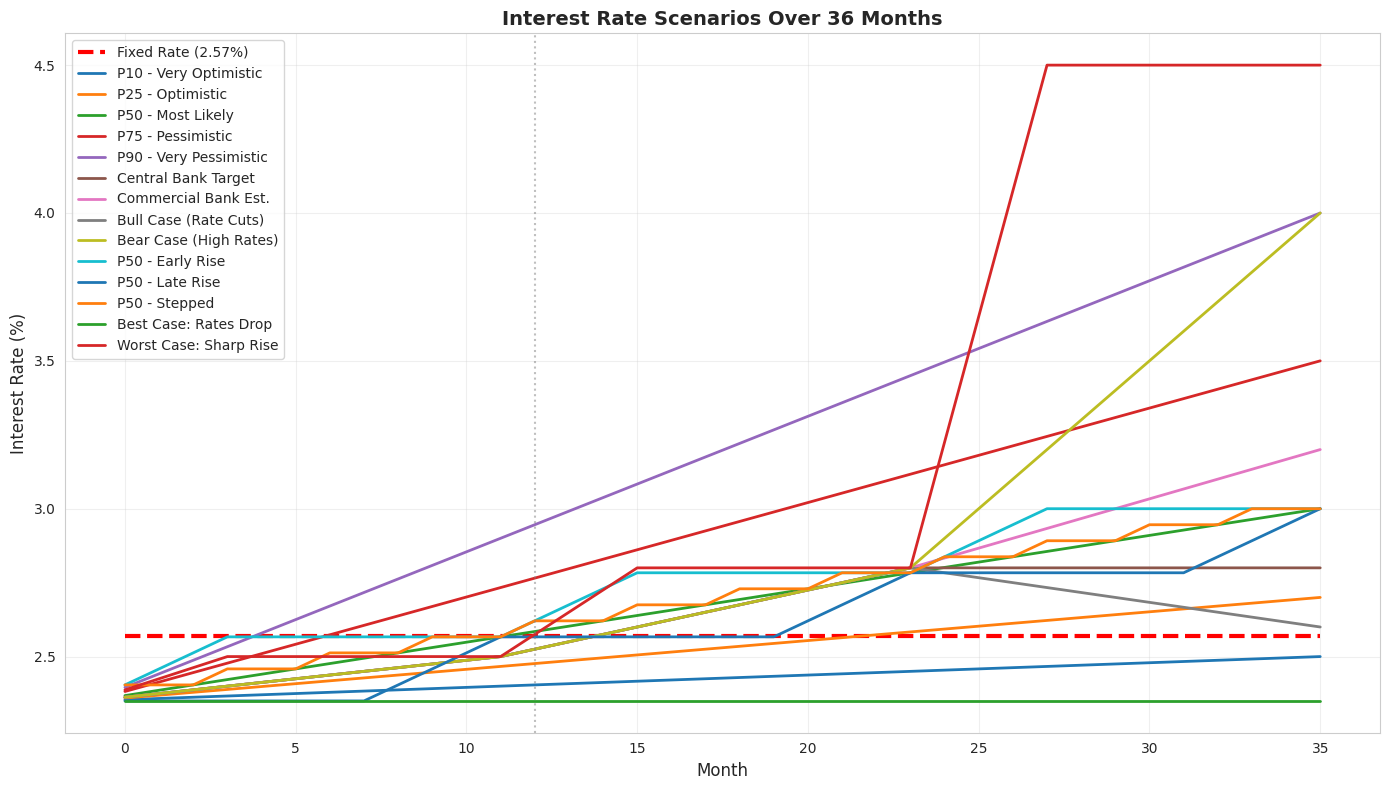

In [29]:
plt.figure(figsize=(14, 8))

# Plot each scenario
for column in df_rates.columns:
    if 'Fixed' in column:
        plt.plot(df_rates.index, df_rates[column], 
                label=column, linewidth=3, linestyle='--', color='red')
    else:
        plt.plot(df_rates.index, df_rates[column], label=column, linewidth=2)

plt.xlabel('Month', fontsize=12)
plt.ylabel('Interest Rate (%)', fontsize=12)
plt.title('Interest Rate Scenarios Over 36 Months', fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.axvline(x=12, color='gray', linestyle=':', alpha=0.5, label='End of Steady Period')
plt.tight_layout()
plt.show()

## Calculate Monthly Costs (Interest + Amortization)

In [30]:
def calculate_monthly_interest(loan_amount, annual_rate_percent):
    """
    Calculate monthly interest cost (interest-only, no amortization)
    """
    monthly_rate = annual_rate_percent / 100 / 12
    return loan_amount * monthly_rate

def calculate_monthly_amortization(loan_amount, annual_amortization_percent):
    """
    Calculate monthly amortization payment
    In Sweden, typical requirement is 2% of the loan amount per year
    """
    annual_amortization = loan_amount * (annual_amortization_percent / 100)
    return annual_amortization / 12

def calculate_total_monthly_cost(loan_amount, annual_rate_percent, annual_amortization_percent):
    """
    Calculate total monthly cost including both interest and amortization
    """
    interest = calculate_monthly_interest(loan_amount, annual_rate_percent)
    amortization = calculate_monthly_amortization(loan_amount, annual_amortization_percent)
    return interest + amortization

# Calculate monthly costs for each scenario
df_monthly_costs = pd.DataFrame()
df_monthly_interest = pd.DataFrame()
df_monthly_amortization = pd.DataFrame()

# Monthly amortization is constant
monthly_amortization = calculate_monthly_amortization(loan_amount, amortization_rate)

print(f"Monthly Amortization Payment: {monthly_amortization:,.0f} SEK")
print(f"Annual Amortization: {monthly_amortization * 12:,.0f} SEK")
print(f"=" * 80)

for column in df_rates.columns:
    df_monthly_interest[column] = df_rates[column].apply(
        lambda rate: calculate_monthly_interest(loan_amount, rate)
    )
    # Total cost = Interest + Amortization
    df_monthly_costs[column] = df_monthly_interest[column] + monthly_amortization

print("\nMonthly Total Costs (Interest + Amortization, SEK)")
print("=" * 80)
df_monthly_costs.head(15)

Monthly Interest Costs (SEK)


,Fixed Rate (2.57%),P10 - Very Optimistic,P25 - Optimistic,P50 - Most Likely,P75 - Pessimistic,P90 - Very Pessimistic,Central Bank Target,Commercial Bank Est.,Bull Case (Rate Cuts),Bear Case (High Rates),P50 - Early Rise,P50 - Late Rise,P50 - Stepped,Best Case: Rates Drop,Worst Case: Sharp Rise
Month,,,,,,,,,,,,,,,
0,4906.558333,4494.496528,4505.103009,4521.012731,4547.528935,4574.045139,4510.406250,4510.406250,4510.406250,4510.406250,4589.954861,4486.541667,4589.954861,4486.541667,4558.135417
1,4906.558333,4502.451389,4523.664352,4555.483796,4608.516204,4661.548611,4534.270833,4534.270833,4534.270833,4534.270833,4693.368056,4486.541667,4589.954861,4486.541667,4629.729167
2,4906.558333,4510.406250,4542.225694,4589.954861,4669.503472,4749.052083,4558.135417,4558.135417,4558.135417,4558.135417,4796.781250,4486.541667,4589.954861,4486.541667,4701.322917
3,4906.558333,4518.361111,4560.787037,4624.425926,4730.490741,4836.555556,4582.000000,4582.000000,4582.000000,4582.000000,4900.194444,4486.541667,4693.368056,4486.541667,4772.916667
4,4906.558333,4526.315972,4579.348380,4658.896991,4791.478009,4924.059028,4605.864583,4605.864583,4605.864583,4605.864583,4900.194444,4486.541667,4693.368056,4486.541667,4772.916667
5,4906.558333,4534.270833,4597.909722,4693.368056,4852.465278,5011.562500,4629.729167,4629.729167,4629.729167,4629.729167,4900.194444,4486.541667,4693.368056,4486.541667,4772.916667
6,4906.558333,4542.225694,4616.471065,4727.839120,4913.452546,5099.065972,4653.593750,4653.593750,4653.593750,4653.593750,4900.194444,4486.541667,4796.781250,4486.541667,4772.916667
7,4906.558333,4550.180556,4635.032407,4762.310185,4974.439815,5186.569444,4677.458333,4677.458333,4677.458333,4677.458333,4900.194444,4486.541667,4796.781250,4486.541667,4772.916667
8,4906.558333,4558.135417,4653.593750,4796.781250,5035.427083,5274.072917,4701.322917,4701.322917,4701.322917,4701.322917,4900.194444,4589.954861,4796.781250,4486.541667,4772.916667


## Visualize Monthly Total Costs

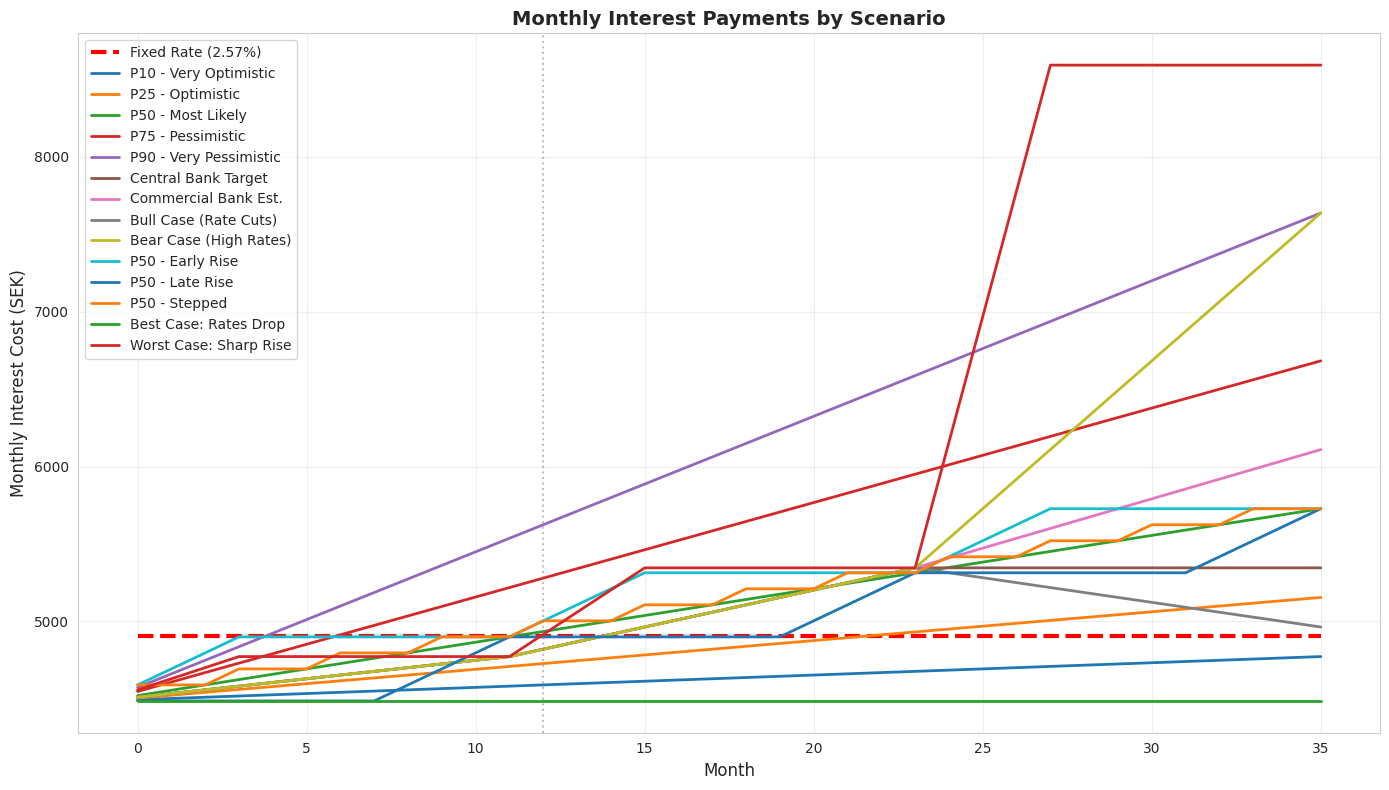

In [ ]:
plt.figure(figsize=(14, 8))

for column in df_monthly_costs.columns:
    if 'Fixed' in column:
        plt.plot(df_monthly_costs.index, df_monthly_costs[column], 
                label=column, linewidth=3, linestyle='--', color='red')
    else:
        plt.plot(df_monthly_costs.index, df_monthly_costs[column], 
                label=column, linewidth=2)

plt.xlabel('Month', fontsize=12)
plt.ylabel('Monthly Total Cost (SEK)', fontsize=12)
plt.title('Monthly Payments (Interest + Amortization) by Scenario', fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.axvline(x=12, color='gray', linestyle=':', alpha=0.5)
plt.tight_layout()
plt.show()

## Calculate Cumulative Total Costs and Savings

In [ ]:
# Calculate cumulative costs
df_cumulative = df_monthly_costs.cumsum()

# Calculate cumulative savings vs. fixed rate
df_savings = pd.DataFrame()
fixed_cumulative = df_cumulative['Fixed Rate (2.57%)']

for column in df_cumulative.columns:
    if column != 'Fixed Rate (2.57%)':  # All columns except the fixed rate
        df_savings[column] = fixed_cumulative - df_cumulative[column]

print("Cumulative Total Cost (Interest + Amortization) Over 36 Months:")
print("=" * 80)
final_costs = df_cumulative.iloc[-1].sort_values()
for scenario, cost in final_costs.items():
    print(f"{scenario:30s}: {cost:>12,.0f} SEK")

print("\n" + "=" * 80)
print("Total Savings vs. Fixed Rate:")
print("=" * 80)
final_savings = df_savings.iloc[-1].sort_values(ascending=False)
for scenario, saving in final_savings.items():
    if saving > 0:
        print(f"{scenario:30s}: +{saving:>11,.0f} SEK (SAVE)")
    else:
        print(f"{scenario:30s}: {saving:>12,.0f} SEK (LOSE)")

Cumulative Total Interest Paid Over 36 Months:
Best Case: Rates Drop         :      161,515 SEK
P10 - Very Optimistic         :      166,813 SEK
P25 - Optimistic              :      173,877 SEK
Fixed Rate (2.57%)            :      176,636 SEK
Bull Case (Rate Cuts)         :      178,364 SEK
P50 - Late Rise               :      179,509 SEK
Central Bank Target           :      180,846 SEK
P50 - Most Likely             :      184,473 SEK
P50 - Stepped                 :      185,714 SEK
Commercial Bank Est.          :      185,810 SEK
P50 - Early Rise              :      189,437 SEK
Bear Case (High Rates)        :      195,737 SEK
P75 - Pessimistic             :      202,133 SEK
Worst Case: Sharp Rise        :      218,361 SEK
P90 - Very Pessimistic        :      219,793 SEK

Total Savings vs. Fixed Rate:
Best Case: Rates Drop         : +     15,121 SEK (SAVE)
P10 - Very Optimistic         : +      9,823 SEK (SAVE)
P25 - Optimistic              : +      2,759 SEK (SAVE)
Bull Case (Rate Cut

## Visualize Cumulative Costs

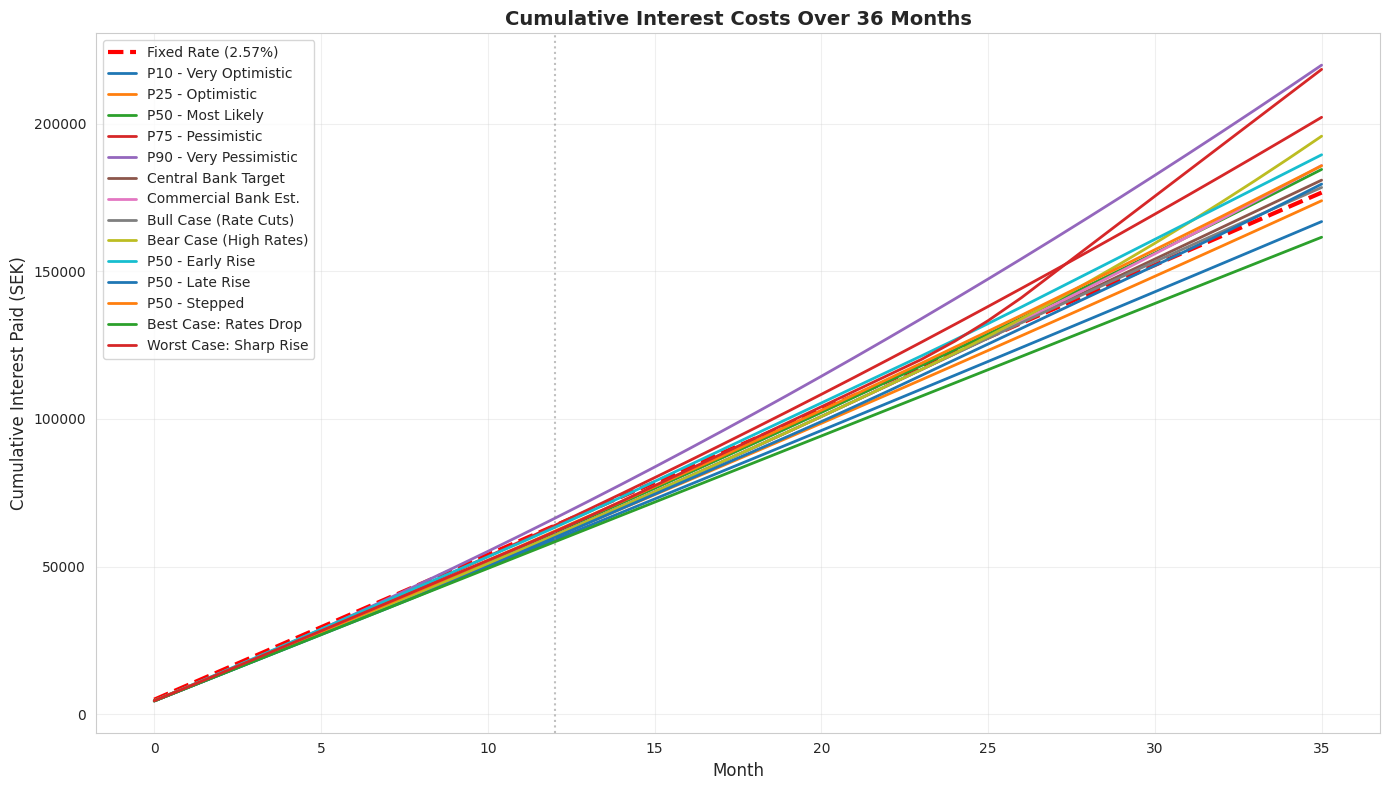

In [ ]:
plt.figure(figsize=(14, 8))

for column in df_cumulative.columns:
    if 'Fixed' in column:
        plt.plot(df_cumulative.index, df_cumulative[column], 
                label=column, linewidth=3, linestyle='--', color='red')
    else:
        plt.plot(df_cumulative.index, df_cumulative[column], 
                label=column, linewidth=2)

plt.xlabel('Month', fontsize=12)
plt.ylabel('Cumulative Total Cost (SEK)', fontsize=12)
plt.title('Cumulative Costs (Interest + Amortization) Over 36 Months', fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.axvline(x=12, color='gray', linestyle=':', alpha=0.5)
plt.tight_layout()
plt.show()

## Visualize Cumulative Savings vs. Fixed Rate

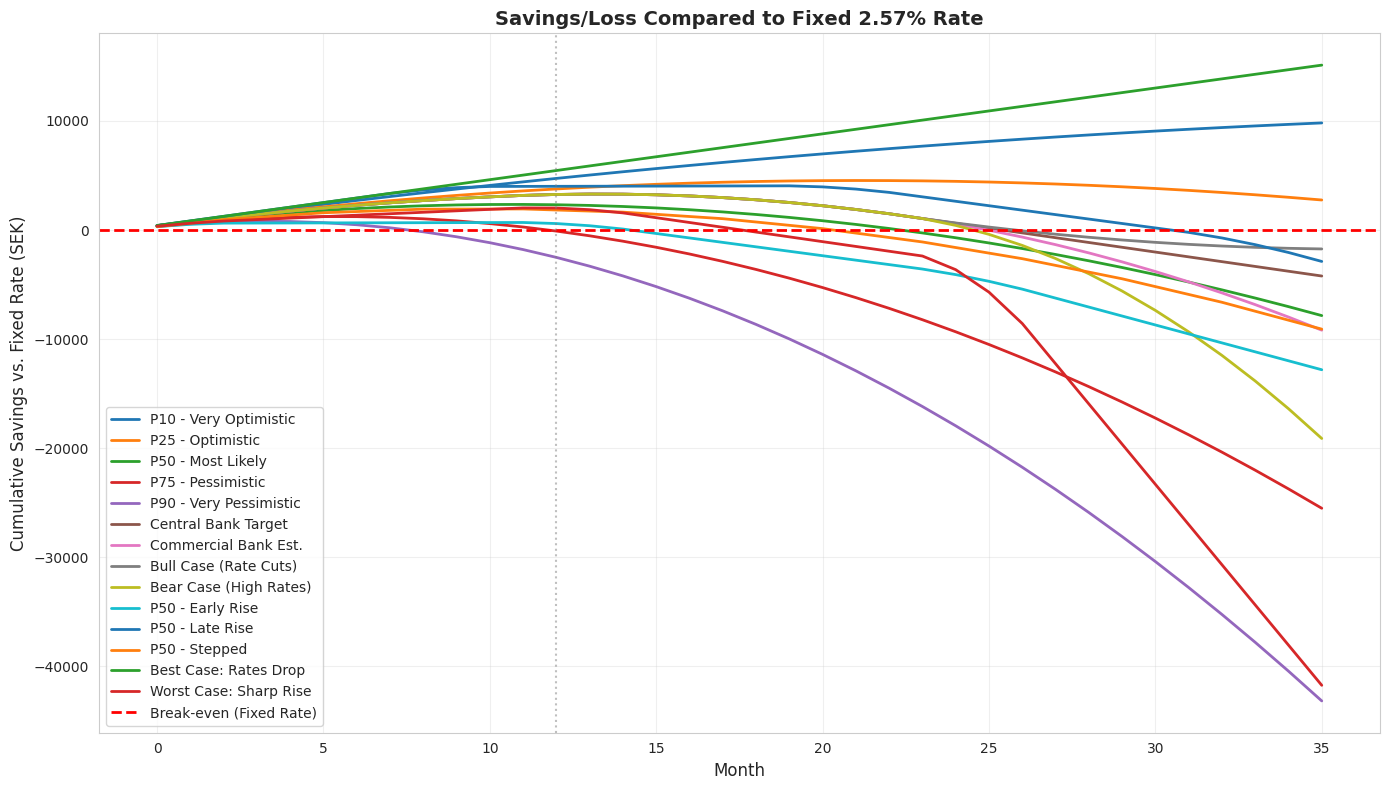

In [34]:
plt.figure(figsize=(14, 8))

for column in df_savings.columns:
    plt.plot(df_savings.index, df_savings[column], label=column, linewidth=2)

plt.axhline(y=0, color='red', linestyle='--', linewidth=2, label='Break-even (Fixed Rate)')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Cumulative Savings vs. Fixed Rate (SEK)', fontsize=12)
plt.title('Savings/Loss Compared to Fixed 2.57% Rate', fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.axvline(x=12, color='gray', linestyle=':', alpha=0.5)
plt.fill_between(df_savings.index, 0, 0, alpha=0.2)
plt.tight_layout()
plt.show()

## Find Break-Even Points

Determine when each variable rate scenario crosses over and becomes more expensive than the fixed rate.

In [35]:
print("Break-Even Analysis:")
print("=" * 80)
print("When does the variable rate become more expensive than fixed 2.57%?\n")

for column in df_savings.columns:
    # Find first month where savings become negative (cumulative cost exceeds fixed)
    negative_months = df_savings[df_savings[column] < 0].index
    
    if len(negative_months) > 0:
        breakeven_month = negative_months[0]
        rate_at_breakeven = df_rates[column].iloc[breakeven_month]
        print(f"{column}:")
        print(f"  - Breaks even at month {breakeven_month}")
        print(f"  - Variable rate at break-even: {rate_at_breakeven:.2f}%")
        print(f"  - Total loss by month 36: {abs(df_savings[column].iloc[-1]):,.0f} SEK\n")
    else:
        print(f"{column}:")
        print(f"  - Never breaks even (always cheaper than fixed)")
        print(f"  - Total savings by month 36: {df_savings[column].iloc[-1]:,.0f} SEK\n")

Break-Even Analysis:
When does the variable rate become more expensive than fixed 2.57%?

P10 - Very Optimistic:
  - Never breaks even (always cheaper than fixed)
  - Total savings by month 36: 9,823 SEK

P25 - Optimistic:
  - Never breaks even (always cheaper than fixed)
  - Total savings by month 36: 2,759 SEK

P50 - Most Likely:
  - Breaks even at month 23
  - Variable rate at break-even: 2.78%
  - Total loss by month 36: 7,837 SEK

P75 - Pessimistic:
  - Breaks even at month 12
  - Variable rate at break-even: 2.77%
  - Total loss by month 36: 25,497 SEK

P90 - Very Pessimistic:
  - Breaks even at month 8
  - Variable rate at break-even: 2.76%
  - Total loss by month 36: 43,157 SEK

Central Bank Target:
  - Breaks even at month 26
  - Variable rate at break-even: 2.80%
  - Total loss by month 36: 4,210 SEK

Commercial Bank Est.:
  - Breaks even at month 25
  - Variable rate at break-even: 2.87%
  - Total loss by month 36: 9,174 SEK

Bull Case (Rate Cuts):
  - Breaks even at month 2

## Summary Statistics

In [36]:
# Create summary table
summary_data = []

for column in df_rates.columns:
    total_cost = df_cumulative[column].iloc[-1]
    avg_rate = df_rates[column].mean()
    max_rate = df_rates[column].max()
    
    if column == 'Fixed Rate (2.57%)':
        savings = 0
    else:
        savings = df_savings[column].iloc[-1]
    
    summary_data.append({
        'Scenario': column,
        'Avg Rate (%)': round(avg_rate, 2),
        'Max Rate (%)': round(max_rate, 2),
        'Total Interest (SEK)': round(total_cost, 0),
        'vs. Fixed (SEK)': round(savings, 0)
    })

df_summary = pd.DataFrame(summary_data)
print("\nSUMMARY: 36-Month Analysis")
print("=" * 100)
print(df_summary.to_string(index=False))

print("\n" + "=" * 100)
print("RECOMMENDATION:")
print("=" * 100)

best_scenario = df_summary.loc[df_summary['Total Interest (SEK)'].idxmin()]
print(f"\nLowest cost: {best_scenario['Scenario']}")
print(f"Total interest: {best_scenario['Total Interest (SEK)']:,.0f} SEK")

if 'Fixed' not in best_scenario['Scenario']:
    print(f"Savings vs. fixed: {best_scenario['vs. Fixed (SEK)']:,.0f} SEK")
    print("\n⚠️  However, this assumes the rate follows the predicted pattern.")
    print("   The fixed rate provides certainty and protection against faster increases.")
else:
    print("\nThe fixed rate is the most expensive option in all tested scenarios.")
    print("Variable rate appears favorable, but carries risk of unpredicted increases.")


SUMMARY: 36-Month Analysis
              Scenario  Avg Rate (%)  Max Rate (%)  Total Interest (SEK)  vs. Fixed (SEK)
    Fixed Rate (2.57%)          2.57          2.57              176636.0              0.0
 P10 - Very Optimistic          2.43          2.50              166813.0           9823.0
      P25 - Optimistic          2.53          2.70              173877.0           2759.0
     P50 - Most Likely          2.68          3.00              184473.0          -7837.0
     P75 - Pessimistic          2.94          3.50              202133.0         -25497.0
P90 - Very Pessimistic          3.20          4.00              219793.0         -43157.0
   Central Bank Target          2.63          2.80              180846.0          -4210.0
  Commercial Bank Est.          2.70          3.20              185810.0          -9174.0
 Bull Case (Rate Cuts)          2.60          2.80              178364.0          -1728.0
Bear Case (High Rates)          2.85          4.00              195737.0

## Calculate Required Variable Rate to Match Fixed Rate

What average rate would the variable rate need to reach to equal the fixed rate cost?

In [38]:
# Total cost with fixed rate
fixed_total_cost = df_cumulative['Fixed Rate (2.57%)'].iloc[-1]

# Calculate what constant rate would give the same total cost
monthly_payment_fixed = fixed_total_cost / total_months
equivalent_annual_rate = (monthly_payment_fixed / loan_amount) * 12 * 100

print(f"Fixed Rate Total Cost: {fixed_total_cost:,.0f} SEK over 36 months")
print(f"\nTo match this cost, a constant variable rate would need to be: {equivalent_annual_rate:.2f}%")
print(f"Current fixed rate: {fixed_rate}%")
print(f"\nThis confirms the calculation is correct (should match: {fixed_rate}%)\n")

print("=" * 80)
print("KEY INSIGHT:")
print("=" * 80)
print(f"\nIf the variable rate AVERAGES more than {fixed_rate}% over 36 months,")
print(f"you would have been better off with the fixed {fixed_rate}% rate.\n")

# Check which scenarios exceed this
print("Average rates by scenario:")
for column in df_rates.columns:
    avg = df_rates[column].mean()
    if avg > fixed_rate:
        print(f"  {column:30s}: {avg:.2f}% (WORSE than fixed)")
    else:
        print(f"  {column:30s}: {avg:.2f}% (better than fixed)")

Fixed Rate Total Cost: 176,636 SEK over 36 months

To match this cost, a constant variable rate would need to be: 2.57%
Current fixed rate: 2.57%

This confirms the calculation is correct (should match: 2.57%)

KEY INSIGHT:

If the variable rate AVERAGES more than 2.57% over 36 months,
you would have been better off with the fixed 2.57% rate.

Average rates by scenario:
  Fixed Rate (2.57%)            : 2.57% (better than fixed)
  P10 - Very Optimistic         : 2.43% (better than fixed)
  P25 - Optimistic              : 2.53% (better than fixed)
  P50 - Most Likely             : 2.68% (WORSE than fixed)
  P75 - Pessimistic             : 2.94% (WORSE than fixed)
  P90 - Very Pessimistic        : 3.20% (WORSE than fixed)
  Central Bank Target           : 2.63% (WORSE than fixed)
  Commercial Bank Est.          : 2.70% (WORSE than fixed)
  Bull Case (Rate Cuts)         : 2.60% (WORSE than fixed)
  Bear Case (High Rates)        : 2.85% (WORSE than fixed)
  P50 - Early Rise              : 